In [14]:
import json
import os
from nuscenes import NuScenes
from nuscenes.eval.common.loaders import load_prediction, load_gt, add_center_dist, filter_eval_boxes
from nuscenes.eval.tracking.loaders import create_tracks
from nuscenes.eval.tracking.data_classes import TrackingBox
from nuscenes.eval.common.config import config_factory
import math
import pandas as pd
import numpy as np
from pyquaternion import Quaternion
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import cv2 
from tqdm import tqdm

def check_occlusion(nusc, other_anns, bbox_2d, camera_name, iou_thresh=0.5):
    """
    Check if the current annotation's 2D bbox is occluded by other annotations.
    
    Parameters:
    -----------
    nusc : NuScenes object
    other_anns : list of annotation tokens in the same sample
    bbox_2d : list, [x_min, y_min, x_max, y_max] of current annotation
    camera_name : str, camera used for projection (e.g., 'CAM_FRONT')
    iou_thresh : float, occlusion threshold (default 0.5 for 50%)
    
    Returns:
    --------
    bool : True if occluded by > iou_thresh, False otherwise
    """
    # Calculate area of current bbox
    curr_area = (bbox_2d[2] - bbox_2d[0]) * (bbox_2d[3] - bbox_2d[1])
    
    # Check each other annotation
    for other_token in other_anns:
        other_ann = nusc.get('sample_annotation', other_token)
        # print(other_ann)
        # Get 2D bbox for this other annotation in the same camera
        _, other_bbox, _ = get_2d_bbox_for_annotation(nusc, other_ann, camera_name, min_bbox_area=0)
        # print(other_bbox)
        
        if other_bbox is None:
            continue  # Not visible in this camera or too small to consider
        
        # Calculate intersection area
        x_left = max(bbox_2d[0], other_bbox[0])
        y_top = max(bbox_2d[1], other_bbox[1])
        x_right = min(bbox_2d[2], other_bbox[2])
        y_bottom = min(bbox_2d[3], other_bbox[3])
        
        # Check if there's an intersection
        if x_right < x_left or y_bottom < y_top:
            continue  # No intersection
        
        # Calculate intersection area
        intersection_area = (x_right - x_left) * (y_bottom - y_top)
        
        # Calculate occlusion ratio (intersection / current bbox area)
        occlusion_ratio = intersection_area / curr_area
        
        # If this other bbox occludes more than threshold, return True
        if occlusion_ratio > iou_thresh:
            return True

    return False  # No significant occlusion found

def get_2d_bbox_for_annotation(nusc, annotation, cam_name, min_bbox_area=5000):
    """
    Project the 3D bounding box to 2D image coordinates for a specific camera.

    Returns: (image_filename, bbox_2d, camera_intrinsic)
        bbox_2d: [x_min, y_min, x_max, y_max] or None if not visible or too small
    """
    # Get the sample for this annotation
    sample = nusc.get('sample', annotation['sample_token'])
    
    # Get camera data
    cam_token = sample['data'][cam_name]
    cam_data = nusc.get('sample_data', cam_token)
    
    # Get image filename
    image_filename = cam_data['filename']
    
    # Get camera calibration
    cs_record = nusc.get('calibrated_sensor', cam_data['calibrated_sensor_token'])
    cam_intrinsic = np.array(cs_record['camera_intrinsic'])
    
    # Get the annotation's 3D bounding box
    bbox_center = np.array(annotation['translation'])
    bbox_size = np.array(annotation['size'])  # [width, length, height]
    bbox_rotation = Quaternion(annotation['rotation'])
    
    # Create 8 corners of the 3D bounding box
    w, l, h = bbox_size
    corners_local = np.array([
        [-w/2, -l/2, -h/2],
        [ w/2, -l/2, -h/2],
        [ w/2,  l/2, -h/2],
        [-w/2,  l/2, -h/2],
        [-w/2, -l/2,  h/2],
        [ w/2, -l/2,  h/2],
        [ w/2,  l/2,  h/2],
        [-w/2,  l/2,  h/2],
    ])
    
    # Rotate corners to global frame
    corners_global = np.array([bbox_rotation.rotate(c) + bbox_center for c in corners_local])
    
    # Transform from global to ego frame
    ego_pose = nusc.get('ego_pose', cam_data['ego_pose_token'])
    ego_translation = np.array(ego_pose['translation'])
    ego_rotation = Quaternion(ego_pose['rotation'])
    corners_ego = np.array([ego_rotation.inverse.rotate(c - ego_translation) for c in corners_global])
    
    # Transform from ego to camera frame
    cam_translation = np.array(cs_record['translation'])
    cam_rotation = Quaternion(cs_record['rotation'])
    corners_cam = np.array([cam_rotation.inverse.rotate(c - cam_translation) for c in corners_ego])
    
    # Filter points behind the camera
    valid_corners = corners_cam[corners_cam[:, 2] > 0]
    if len(valid_corners) == 0:
        return image_filename, None, cam_intrinsic
    
    # Project to image plane
    points_img = []
    for c in valid_corners:
        uv = cam_intrinsic @ c
        uv = uv[:2] / uv[2]
        points_img.append(uv)
    points_img = np.array(points_img)

    # Compute bbox
    x_min, y_min = points_img.min(axis=0)
    x_max, y_max = points_img.max(axis=0)
    
    # Clip to image
    imsize = (cam_data['width'], cam_data['height'])
    x_min, y_min = max(0, x_min), max(0, y_min)
    x_max, y_max = min(imsize[0], x_max), min(imsize[1], y_max)
    if x_max <= x_min or y_max <= y_min:
        return image_filename, None, cam_intrinsic

    # Check size (area threshold)
    area = (x_max - x_min) * (y_max - y_min)
    # print(area)
    if area < min_bbox_area:  # <-- new condition here
        return image_filename, x, cam_intrinsic
    
    bbox_2d = [x_min, y_min, x_max, y_max]
    return image_filename, bbox_2d, cam_intrinsic


def compute_movement_from_gcs(df, outlier_speed_thresh=None):
    """
    df: pandas DataFrame with columns ['timestamp', 'x', 'y', 'z'].
        - timestamps must be sortable. If using nuScenes raw timestamps (microseconds),
          divide by 1e6 before calling or set time_unit_seconds=False to convert in function.
    time_unit_seconds: if False, will assume timestamps are in microseconds and convert.
    outlier_speed_thresh: optional float in m/s; any instantaneous speed > thresh will be
        considered outlier and removed from cumulative path length (set its d_i to 0).
    Returns: dict with arrays and summary metrics.
    """
    df = df.sort_values('timestamp').reset_index(drop=True).copy()

    # compute diffs
    dt = df['timestamp'].diff().to_numpy()         
    dx = df['x'].diff().to_numpy()
    dy = df['y'].diff().to_numpy()
    dz = df['z'].diff().to_numpy()

    # first row is NaN diff => set to 0
    dt[0] = np.nan
    dx[0] = dy[0] = dz[0] = np.nan

    # distances and speeds
    d = np.sqrt(dx**2 + dy**2 + dz**2)   # meters
    with np.errstate(divide='ignore', invalid='ignore'):
        v = d / dt                        # m/nuscene ts

    # optional outlier removal
    if outlier_speed_thresh is not None:
        mask = (v > outlier_speed_thresh)
        d[mask] = 0.0
        v[mask] = np.nan

    cumulative_path = np.nansum(d)  # total distance in meters
    net_disp = np.linalg.norm([df['x'].iloc[-1] - df['x'].iloc[0],
                               df['y'].iloc[-1] - df['y'].iloc[0],
                               df['z'].iloc[-1] - df['z'].iloc[0]])
    total_time = df['timestamp'].iloc[-1] - df['timestamp'].iloc[0]
    avg_speed = cumulative_path / total_time if total_time > 0 else np.nan

    # Straightness: net / path (guard divide-by-zero)
    straightness = net_disp / cumulative_path if cumulative_path > 0 else np.nan

    return {
        # 'timestamps': df['timestamp'].to_numpy(),
        # 'dx': dx, 'dy': dy, 'dz': dz,
        # 'dt': dt, 'distances': d, 'speeds': v,
        'cumulative_path': cumulative_path,
        'net_displacement': net_disp,
        'total_time': total_time,
        'average_speed': avg_speed,
        'straightness': straightness,
        'class': df['tracking_name'].iloc[0],
        'tracking_id': df['tracking_id'].iloc[0]
    }



def get_best_camera_for_annotation(nusc, annotation):
    """
    Find the camera with the most coverage of the annotation's bounding box.
    
    Returns: (camera_name, coverage_score)
    """
    sample = nusc.get('sample', annotation['sample_token'])
    bbox_center = np.array(annotation['translation'])
    
    cameras = ['CAM_FRONT', 'CAM_FRONT_RIGHT', 'CAM_BACK_RIGHT', 
               'CAM_BACK', 'CAM_BACK_LEFT', 'CAM_FRONT_LEFT']
    
    best_camera = None
    max_coverage = -1
    
    for cam_name in cameras:
        cam_token = sample['data'][cam_name]
        cam_data = nusc.get('sample_data', cam_token)
        cs_record = nusc.get('calibrated_sensor', cam_data['calibrated_sensor_token'])
        cam_intrinsic = np.array(cs_record['camera_intrinsic'])
        ego_pose = nusc.get('ego_pose', cam_data['ego_pose_token'])
        
        # Transform to camera frame
        bbox_center_ego = bbox_center - np.array(ego_pose['translation'])
        bbox_center_ego = Quaternion(ego_pose['rotation']).inverse.rotate(bbox_center_ego)
        bbox_center_cam = bbox_center_ego - np.array(cs_record['translation'])
        bbox_center_cam = Quaternion(cs_record['rotation']).inverse.rotate(bbox_center_cam)
        
        if bbox_center_cam[2] <= 0:
            continue
        
        # Project center to image plane
        point_cam = np.array([bbox_center_cam[0], bbox_center_cam[1], bbox_center_cam[2]])
        point_img = np.dot(cam_intrinsic, point_cam)
        point_img = point_img[:2] / point_img[2]
        
        imsize = (cam_data['width'], cam_data['height'])
        x, y = point_img
        in_image = (0 <= x < imsize[0]) and (0 <= y < imsize[1])
        
        if in_image:
            distance = np.linalg.norm(bbox_center_cam)
            center_x, center_y = imsize[0] / 2, imsize[1] / 2
            offset = np.sqrt((x - center_x)**2 + (y - center_y)**2)
            coverage = 1.0 / (distance * (1 + offset / 1000))
            
            if coverage > max_coverage:
                max_coverage = coverage
                best_camera = cam_name
    
    return best_camera, max_coverage

def visualize_track_grid(tracking_results, dataroot, save_path='bicycle_track_grid.png', 
                         cols=4, figsize_per_image=(4, 3), dpi=150):
    """
    Create a grid visualization of all frames in a track with bounding boxes.
    
    Parameters:
    -----------
    nusc : NuScenes object
    tracking_results : list of dicts with 'image_file', 'bbox_2d', 'camera', 'frame'
    dataroot : str, path to nuScenes data root
    save_path : str, where to save the output image
    cols : int, number of columns in the grid
    figsize_per_image : tuple, (width, height) for each subplot
    dpi : int, resolution of saved image
    """
    n_frames = len(tracking_results)
    rows = int(np.ceil(n_frames / cols))
    
    fig, axes = plt.subplots(rows, cols, figsize=(figsize_per_image[0]*cols, figsize_per_image[1]*rows))
    fig.suptitle(f'Bicycle Track - {n_frames} Frames', fontsize=16, fontweight='bold')
    
    # Flatten axes for easy iteration
    if n_frames == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    for idx, result in tracking_results.iterrows():
        ax = axes[idx]
        
        # Load image
        img_path = os.path.join(dataroot, result['filename'])
        img = Image.open(img_path)
        
        # Display image
        ax.imshow(img)
        
        # Draw bounding box
        bbox = result['bbox_2d']
        x_min, y_min, x_max, y_max = bbox
        width = x_max - x_min
        height = y_max - y_min
        
        rect = patches.Rectangle((x_min, y_min), width, height, 
                                 linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        
        # Add frame info
        # camera_short = result['camera'].replace('CAM_', '')
        # ax.set_title(f"Frame {result['frame']}\n{camera_short}", fontsize=10)
        # ax.axis('off')
    
    # Hide empty subplots
    for idx in range(n_frames, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=dpi, bbox_inches='tight')
    print(f"Grid visualization saved to: {save_path}")
    plt.show()


def visualize_single_frame(result, dataroot, save_path=None):
    """
    Visualize a single frame with bounding box (useful for detailed inspection).
    
    Parameters:
    -----------
    nusc : NuScenes object
    result : dict with 'image_file', 'bbox_2d', 'camera', 'frame'
    dataroot : str, path to nuScenes data root
    save_path : str or None, where to save the image
    """
    # Load image
    img_path = os.path.join(dataroot, result['image_file'])
    img = Image.open(img_path)
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    ax.imshow(img)
    
    # Draw bounding box
    bbox = result['bbox_2d']
    x_min, y_min, x_max, y_max = bbox
    width = x_max - x_min
    height = y_max - y_min
    
    rect = patches.Rectangle((x_min, y_min), width, height, 
                             linewidth=3, edgecolor='red', facecolor='none')
    ax.add_patch(rect)
    
    # Add label
    ax.text(x_min, y_min - 10, 'Bicycle', 
            color='red', fontsize=12, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
    
    # camera_short = result['camera'].replace('CAM_', '')
    # ax.set_title(f"Frame {result['frame']} - {camera_short}", fontsize=14, fontweight='bold')
    # ax.axis('off')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Frame saved to: {save_path}")
    
    plt.show()

# EDA over the ground truth validation set, prediction accuracies

In [15]:
metrics_path = "results/nuscenes/20250921_Original/eval_result/metrics_summary.json"
with open(metrics_path) as f:
    summary = json.load(f)
amota_dict = summary['label_metrics']['amota']
worst_classes = sorted(amota_dict.items(), key=lambda x: x[1])
print(worst_classes)

[('trailer', 0.5338312786215667), ('bicycle', 0.5739121077309763), ('truck', 0.7168514820778975), ('motorcycle', 0.7680373397027292), ('pedestrian', 0.8327717124341767), ('car', 0.8705222982697165), ('bus', 0.8829414993181077)]


In [16]:
worst_classes

[('trailer', 0.5338312786215667),
 ('bicycle', 0.5739121077309763),
 ('truck', 0.7168514820778975),
 ('motorcycle', 0.7680373397027292),
 ('pedestrian', 0.8327717124341767),
 ('car', 0.8705222982697165),
 ('bus', 0.8829414993181077)]

In [11]:
# Sort by MOTA ascending (worst first)
worst_classes = sorted(worst_classes, key=lambda x: x[1])
print("Worst performing classes:", worst_classes[:3])

Worst performing classes: [('trailer', 0.5338312786215667), ('bicycle', 0.5739121077309763), ('truck', 0.7168514820778975)]


In [12]:
velocity_all = pd.DataFrame()
velocity_results = ["motion_eval_velocity_kalman_cv.csv", "motion_eval_velocity_det.csv","motion_eval_velocity_diff.csv","motion_eval_velocity_curve.csv"]
for name in velocity_results:
    df = pd.read_csv(name)
    df["name"] = f"{name}"
    df = df.rename(columns={"Unnamed: 0": "class"})
    velocity_all = pd.concat([velocity_all, df], ignore_index=True)

FileNotFoundError: [Errno 2] No such file or directory: 'motion_eval_velocity_kalman_cv.csv'

In [5]:
kf_metrics = velocity_all[velocity_all["name"] == "motion_eval_velocity_kalman_cv.csv"].groupby("class").mean().sort_values('vae', ascending=True)
kf_metrics.sort_values('vde', ascending=True)

KeyError: 'name'

In [176]:
# 2. Load tracks for those classes
cfg = config_factory('tracking_nips_2019')
nusc = NuScenes(version=version, dataroot=dataroot, verbose=True)

Loading NuScenes tables for version v1.0-trainval...
23 category,
8 attribute,
4 visibility,
64386 instance,
12 sensor,
10200 calibrated_sensor,
2631083 ego_pose,
68 log,
850 scene,
34149 sample,
2631083 sample_data,
1166187 sample_annotation,
4 map,
Done loading in 31.670 seconds.
Reverse indexing ...
Done reverse indexing in 6.3 seconds.


In [ ]:
# Load predictions and GT
pred_boxes, meta = load_prediction(result_path, cfg.max_boxes_per_sample, TrackingBox, verbose=True)
gt_boxes = load_gt(nusc, eval_set, TrackingBox, verbose=True)

In [11]:
pred_boxes = add_center_dist(nusc, pred_boxes)
gt_boxes = add_center_dist(nusc, gt_boxes)
pred_boxes = filter_eval_boxes(nusc, pred_boxes, cfg.class_range, verbose=True)
gt_boxes = filter_eval_boxes(nusc, gt_boxes, cfg.class_range, verbose=True)

gt_tracks = create_tracks(gt_boxes, nusc, eval_set, gt=True)
pred_tracks = create_tracks(pred_boxes, nusc, eval_set, gt=False)

=> Original number of boxes: 318698
=> After distance based filtering: 244674
=> After LIDAR and RADAR points based filtering: 244674
=> After bike rack filtering: 244321
=> Original number of boxes: 142261
=> After distance based filtering: 103564
=> After LIDAR and RADAR points based filtering: 93885
=> After bike rack filtering: 93875


In [ ]:
rows = []

for scene, timestamps in gt_tracks.items():
    for timestamp, boxes in timestamps.items():
        for box in boxes:
            rows.append([
                scene,
                box.sample_token,
                timestamp,
                box.tracking_id,
                box.tracking_name,
                box.translation,
                box.size,
                box.velocity
            ])

df = pd.DataFrame(rows, columns=[
    "scene", "sample_token", "timestamp", "tracking_id",
    "tracking_name", "translation", "size", "velocity"
])

In [332]:
xyz_cols = df['translation'].apply(pd.Series)
df['x'] = xyz_cols[0]
df['y'] = xyz_cols[1]
df['z'] = xyz_cols[2]

In [343]:
# df[df["tracking_id"] == '000c78f1dbad49eca9ca20c908c3836b']
set(df['tracking_name'])

{'bicycle', 'bus', 'car', 'motorcycle', 'pedestrian', 'trailer', 'truck'}

In [372]:
rows = []
for group,data in df[df["tracking_name"]!="pedestrian"].groupby("tracking_id"):
    # print(group, len(data))
    rows.append(compute_movement_from_gcs(data))
consider_stationary = pd.DataFrame(rows)

In [373]:
# pseudo ground truth
# confirm that bike and trailer have the most "ghost movement" measurement noise
consider_stationary.groupby("class").agg({'cumulative_path':'mean','net_displacement':'mean','straightness':'mean'}).sort_values('straightness', ascending=True)

,cumulative_path,net_displacement,straightness
class,,,
motorcycle,13.424646,12.216324,0.642579
trailer,4.402676,3.795591,0.651312
bicycle,4.043050,3.564005,0.664257
truck,10.585122,9.530011,0.666380
car,13.260199,12.118353,0.666404
bus,26.191042,23.068743,0.747611


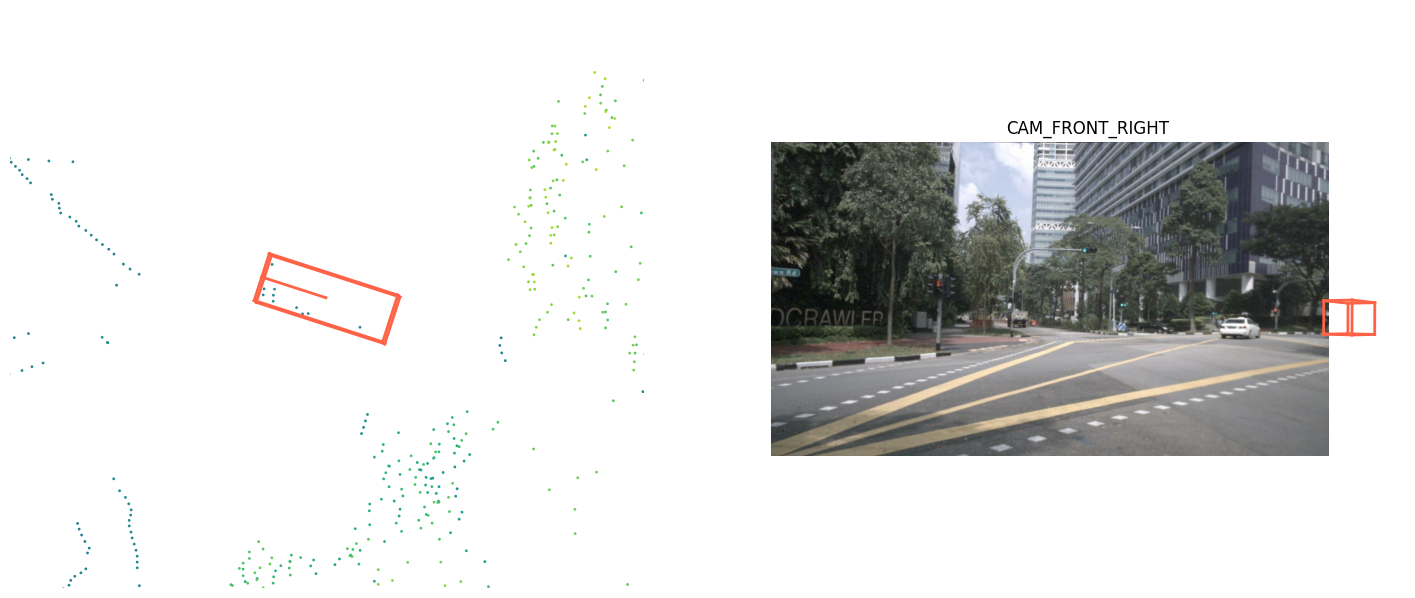

In [351]:
instance = nusc.get("instance","0015869c06d34f44988f73b290478768")
token = instance["token"]
nusc.render_instance(token)

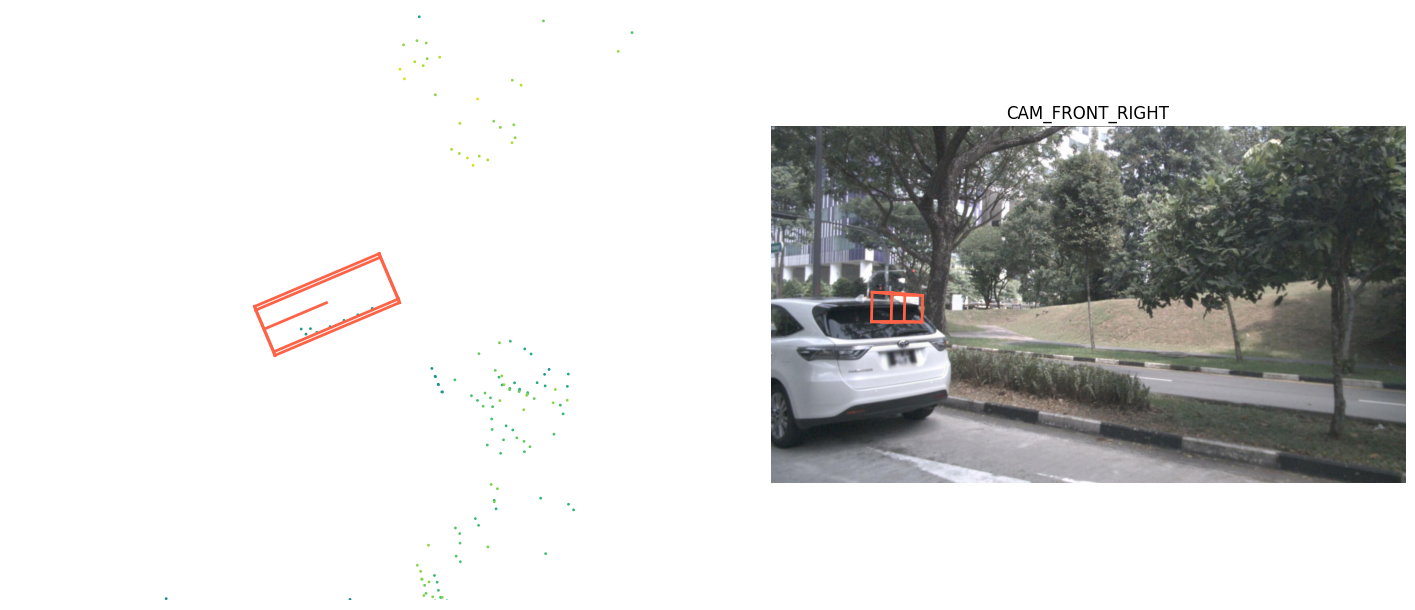

In [ ]:
first_token = instance["first_annotation_token"]
nusc.render_annotation(first_token)

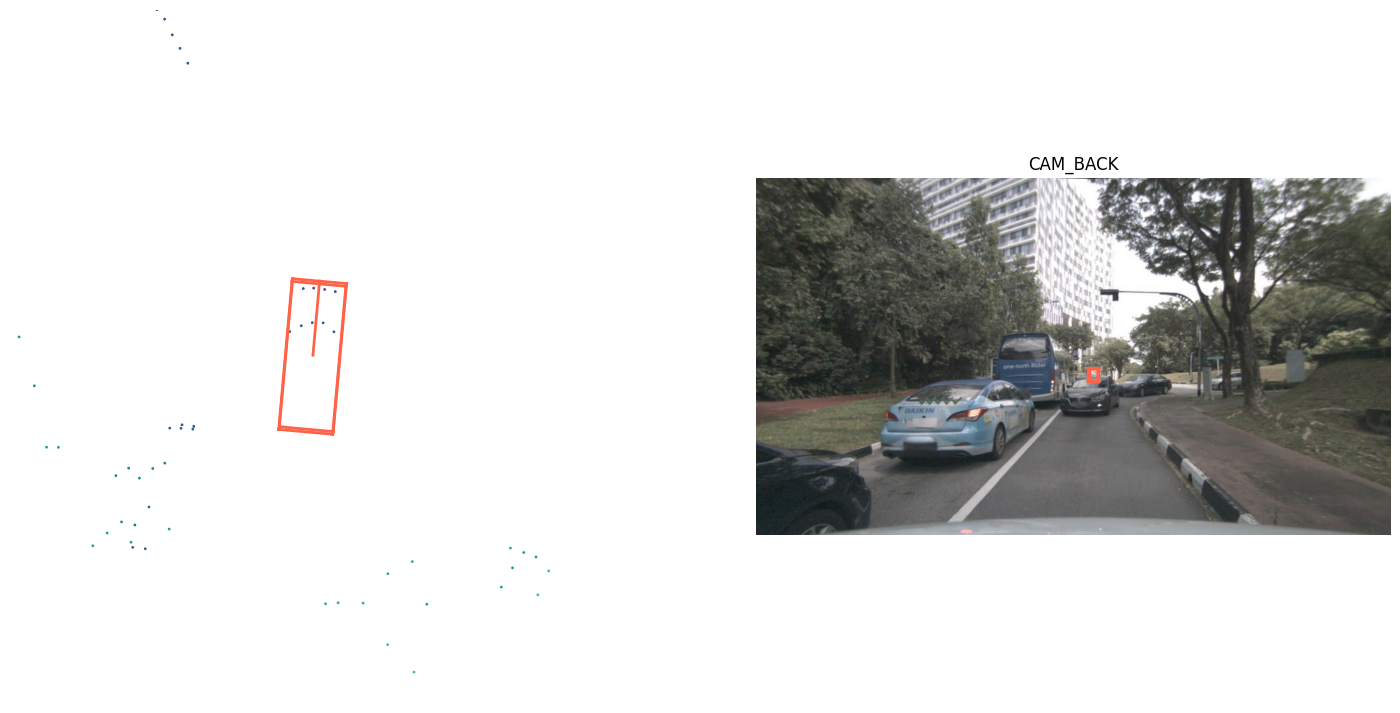

In [349]:
last_token = instance["last_annotation_token"]
nusc.render_annotation(last_token)

# Compile NN Classifier Training Data!

In [ ]:
cfg = config_factory('tracking_nips_2019')
metrics_path = r"c:\Users\RautaN01\Documents\Nuscenes\MCTrack\results\nuscenes\20250921_201954\eval_result\metrics_summary.json"
result_path = r"c:\Users\RautaN01\Documents\Nuscenes\MCTrack\results\nuscenes\20250921_201954\results.json"
dataroot = r"data/nuscenes/datasets/"
version = "v1.0-trainval"
nusc = NuScenes(version=version, dataroot=dataroot, verbose=True)

Loading NuScenes tables for version v1.0-trainval...
23 category,
8 attribute,
4 visibility,
64386 instance,
12 sensor,
10200 calibrated_sensor,
2631083 ego_pose,
68 log,
850 scene,
34149 sample,
2631083 sample_data,
1166187 sample_annotation,
4 map,
Done loading in 25.441 seconds.
Reverse indexing ...
Done reverse indexing in 6.3 seconds.


In [130]:
eval_set = "train"

In [131]:
gt_boxes_train = load_gt(nusc, eval_set, TrackingBox, verbose=True)
gt_boxes_train = add_center_dist(nusc, gt_boxes_train)
gt_boxes_train = filter_eval_boxes(nusc, gt_boxes_train, cfg.class_range, verbose=True)
gt_tracks = create_tracks(gt_boxes_train, nusc, eval_set, gt=True)

Loading annotations for train split from nuScenes version: v1.0-trainval


100%|██████████| 28130/28130 [00:20<00:00, 1368.57it/s]


Loaded ground truth annotations for 28130 samples.
=> Original number of boxes: 725431
=> After distance based filtering: 539916
=> After LIDAR and RADAR points based filtering: 487022
=> After bike rack filtering: 487022


In [132]:
rows = []

for scene, timestamps in gt_tracks.items():
    for timestamp, boxes in timestamps.items():
        for box in boxes:
            rows.append([
                scene,
                box.sample_token,
                timestamp,
                box.tracking_id,
                box.tracking_name,
                box.translation,
                box.size,
                box.velocity
            ])

df = pd.DataFrame(rows, columns=[
    "scene", "sample_token", "timestamp", "tracking_id",
    "tracking_name", "translation", "size", "velocity"
])


xyz_cols = df['translation'].apply(pd.Series)
df['x'] = xyz_cols[0]
df['y'] = xyz_cols[1]
df['z'] = xyz_cols[2]


rows = []
for group,data in df[df["tracking_name"].isin(["bicycle","trailer"])].groupby("tracking_id"):
    # print(group, len(data))
    rows.append(compute_movement_from_gcs(data))
consider_stationary = pd.DataFrame(rows)


stationary_meters_thresh = 1/6 #meters per second
consider_stationary['total_time_s'] = consider_stationary['total_time']/(1e6)
consider_stationary["flag"] = 0
consider_stationary.loc[consider_stationary['cumulative_path'] < consider_stationary['total_time_s']*stationary_meters_thresh, 'flag'] = 1


training_datastore = pd.DataFrame(columns = ['tracking_id','target','class','bbox_2d','coverage_score','filename'])
for index, row in tqdm(consider_stationary[['tracking_id','flag','class']].iterrows(), 
                       total=len(consider_stationary),
                       desc="Processing tracks"):
    # print(index)
    # print("_______________________________")
    target = row['flag']
    class_name = row['class']
    track_id = row['tracking_id']
    track = nusc.get("instance", track_id)

    first_annotation = nusc.get('sample_annotation', track['first_annotation_token'])
    last_annotation_token = track['last_annotation_token']
    
    curr_annotation = first_annotation
    other_anns = nusc.get('sample',curr_annotation['sample_token'])['anns']
    if curr_annotation['token'] in other_anns: 
        # print("here")
        other_anns.remove(curr_annotation['token'])

    frame_num = 0
    while True:
        # print(frame_num)
        # print("______________________________")
        # Find best camera for current annotation
        best_cam, coverage = get_best_camera_for_annotation(nusc, curr_annotation)
        # project to RV and get 2D bbox
        if best_cam is None:
            image_file, bbox_2d, cam_intrinsic = None, "No Camera Shows Object Well Enough", None
        else:
            image_file, bbox_2d, cam_intrinsic = get_2d_bbox_for_annotation(nusc, curr_annotation, best_cam)
            if not bbox_2d:
                image_file, bbox_2d, cam_intrinsic = None, "Object Too Small", None
            else:
                if check_occlusion(nusc, other_anns, bbox_2d, best_cam):
                    image_file, bbox_2d, cam_intrinsic = None, "Object Occluded", None

        training_datastore.loc[len(training_datastore)] = [track_id, target, class_name, bbox_2d, coverage, image_file]
        frame_num += 1
        if curr_annotation['token'] == last_annotation_token:
            break

        curr_annotation = nusc.get('sample_annotation', curr_annotation['next'])
        other_anns = nusc.get('sample',curr_annotation['sample_token'])['anns']
        if curr_annotation['token'] in other_anns: 
            # print("here")
            other_anns.remove(curr_annotation['token'])
    #     if frame_num == 10:
    #         break
    # break

Processing tracks: 100%|██████████| 1292/1292 [07:33<00:00,  2.85it/s]


In [133]:
# sample
#  about 9 good images per track on average
training_datastore.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27361 entries, 0 to 27360
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tracking_id     27361 non-null  object 
 1   target          27361 non-null  int64  
 2   class           27361 non-null  object 
 3   bbox_2d         27361 non-null  object 
 4   coverage_score  27361 non-null  float64
 5   filename        12094 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 1.5+ MB


In [135]:
print(training_datastore[training_datastore['bbox_2d'] == "Object Occluded"].shape[0])
print(training_datastore[training_datastore['bbox_2d'] == "Object Too Small"].shape[0])
print(training_datastore[training_datastore['bbox_2d'] == "No Camera Shows Object Well Enough"].shape[0])
print(training_datastore.shape[0])
print(training_datastore.dropna().shape[0])

9840
5384
43
27361
12094


In [ ]:
set(training_datastore.dropna().tracking_id)

{'a76f10640ad34b53be40d1881aed64a4',
 'ca5d8cd03cbb470ea5531a36b4fa7e9c',
 '3d7bd0a6d0c54b47a8df79ea334ce0ea',
 '0e856e38e93d42f0b63aa0e01bf2106e',
 'd95e428c60d146368efff2e4f35db50b',
 'bf78004bc76e41b395d5457425294276',
 '8be3571e36bd4aeb9922e7c28ece80f1',
 '8c263b7e60154f60a3885965d68e2387',
 '8a5eec2a11764628aea2053af2369422',
 'b1b1f69aa5df4471bf088476339169de',
 'fef1853d920b4b3aa5531afe5a6fbe4d',
 'abecb02dbe8542ceb650d392e7bac440',
 'b570649d7779447aad1e38cdd508ea6f',
 'aa175f2e69be4d64af821dac8653ba2d',
 '31ee8f4b2d284c3a99d8649973281683',
 '7067ef15b587431594c4b3b7e8a11d3d',
 '8a2d4fd1822f4afbafb063f3d05a28b6',
 '84917a00cf844ef4b8315353c28a206b',
 'c3b7a733e8234f999b46df051f7474e8',
 '20340d1f9aee4d4192a247d0f7ca035d',
 'a438d71e445040c7b081be6c2e9c3b70',
 'f2116322856f4a9bb010b76d774c2d1b',
 '5d58952bfbd64ab9a060e901718ee13b',
 'b8fd62d19de7457da0bbf5ae8638ea8b',
 '4f99da0d5309444694a3a79cc5d10c9f',
 'ffe1c3a6e58d4fb7bb4566e344206d02',
 '9d8b8298a12f4f3f98ad3374c3f31c7e',
 

In [141]:
training_datastore.head()

,tracking_id,target,class,bbox_2d,coverage_score,filename
0,001d58d25ed1490b80f7f8834b0a3411,0,trailer,"[144.3833741806294, 355.7352890810371, 489.378...",0.021596,samples/CAM_BACK/n008-2018-05-21-11-06-59-0400...
1,001d58d25ed1490b80f7f8834b0a3411,0,trailer,Object Occluded,0.019807,None
2,001d58d25ed1490b80f7f8834b0a3411,0,trailer,Object Occluded,0.018451,None
3,001d58d25ed1490b80f7f8834b0a3411,0,trailer,"[323.28650756138774, 361.93358875675557, 555.0...",0.017296,samples/CAM_BACK/n008-2018-05-21-11-06-59-0400...
4,001d58d25ed1490b80f7f8834b0a3411,0,trailer,"[352.81079871820964, 361.9501745729982, 566.30...",0.016394,samples/CAM_BACK/n008-2018-05-21-11-06-59-0400...


In [137]:
training_datastore['bbox_2d'] = training_datastore['bbox_2d'].apply(lambda x: str(x))
training_datastore.to_feather( 'cnn_classifier_train_data_restricted.feather')

AttributeError: 'numpy.ndarray' object has no attribute 'imshow'

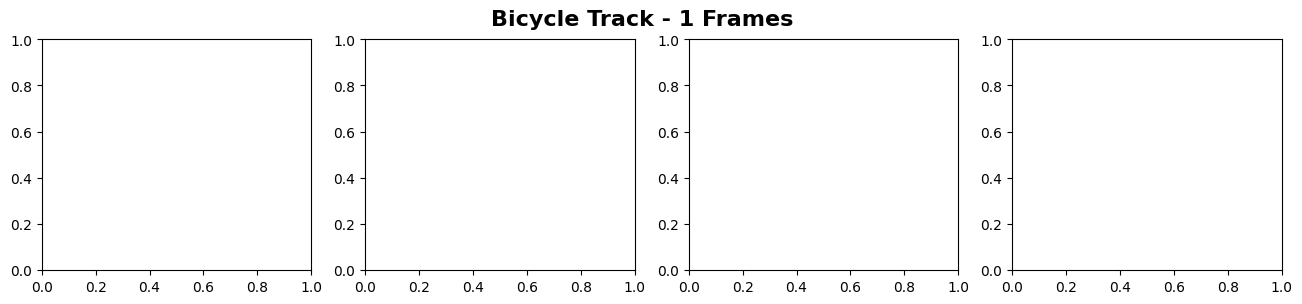

In [140]:
dataroot = 'data/nuscenes/datasets/v1.0-trainval/'
tracking_results = training_datastore[training_datastore['tracking_id'] == 'a76f10640ad34b53be40d1881aed64a4'].dropna().reset_index(drop=True)  

# Create grid visualization
visualize_track_grid(tracking_results, dataroot, 
                    #  save_path='bicycle_track_grid.png',
                     cols=4,  # Adjust number of columns
                     figsize_per_image=(4, 3),
                     dpi=200)

In [ ]:
#### IMPORTANT ROSIE COMMANDS
# scp "C:\Users\RautaN01\Documents\Nuscenes\MCTrack\cnn_classifier_train_data.feather" "rautmanna@ad.msoe.edu@dh-mgmt2.hpc.msoe.edu:~/Documents/Capstone/MCTrack/"
# srun --partition=teaching --gres=gpu:t4:1 python train_classifier.py
# srun --partition=dgxh100 --gres=gpu:h100:1 --pty bash


#### potential blockers:
# RuntimeError: Cannot install on Python version 3.12.11; only versions >=3.8,<3.12 are supported.
# MCTrack was configured to use Python 3.10.0
# Can I install multiple python versions on ROSIE?
# downloading pretrained models from pytorch hub error

#### experiment log
# hyperparam_search_20251018_141843 - initial with messy data
# hyperparam_search_20251022_173141 - cleaner data, same architecture



NameError: name 'python' is not defined

In [6]:
# fix the
import pandas as pd
# t = pd.read_feather("C:/Users/RautaN01/Documents/Nuscenes/MCTrack/llama_results_hand_labeled.feather").dropna()
# t = pd.read_feather('llama_results_hand_labeled_90B_4bit.feather')
t = pd.read_feather('hand_labeled_data_predictions_anti_overfit.feather').dropna()
# t.set_index("filename")

In [7]:
t.shape

(2192, 10)

In [8]:
t

,index,filename,original_label,new_label,bbox_2d,predicted_class,prob_class_0,prob_class_1,model_name,checkpoint_path
0,0,samples/CAM_FRONT_RIGHT/n008-2018-08-30-10-33-...,1,2,"[656.5117765527651, 537.9222516336903, 887.885...",1,0.432906,0.567094,anti_overfit,hyperparam_search_20251024_125918/run_1_anti_o...
1,1,samples/CAM_FRONT_RIGHT/n008-2018-08-30-10-33-...,1,1,"[1028.8755082565865, 556.210386950205, 1292.79...",1,0.356551,0.643449,anti_overfit,hyperparam_search_20251024_125918/run_1_anti_o...
2,2,samples/CAM_BACK_RIGHT/n008-2018-08-30-10-33-5...,1,1,"[214.97063466090373, 594.8816317219759, 497.42...",1,0.320477,0.679523,anti_overfit,hyperparam_search_20251024_125918/run_1_anti_o...
3,3,samples/CAM_BACK_RIGHT/n008-2018-08-30-10-33-5...,1,1,"[758.4580707978948, 566.0271475679108, 960.719...",1,0.397311,0.602689,anti_overfit,hyperparam_search_20251024_125918/run_1_anti_o...
4,4,samples/CAM_BACK_RIGHT/n008-2018-08-30-10-33-5...,1,2,"[1111.4280704281002, 555.0697493500579, 1334.2...",1,0.386269,0.613731,anti_overfit,hyperparam_search_20251024_125918/run_1_anti_o...
...,...,...,...,...,...,...,...,...,...,...
2187,2187,samples/CAM_FRONT_LEFT/n015-2018-09-25-13-17-4...,1,1,"[619.9764683182191, 474.2807701367224, 831.416...",1,0.327950,0.672050,anti_overfit,hyperparam_search_20251024_125918/run_1_anti_o...
2188,2188,samples/CAM_BACK_LEFT/n015-2018-09-25-13-17-43...,1,1,"[1273.3614362722055, 482.12618952317644, 1382....",1,0.387645,0.612355,anti_overfit,hyperparam_search_20251024_125918/run_1_anti_o...
2189,2189,samples/CAM_BACK_LEFT/n015-2018-09-25-13-17-43...,1,1,"[550.3033226972914, 453.7108706331265, 772.769...",1,0.203935,0.796065,anti_overfit,hyperparam_search_20251024_125918/run_1_anti_o...
2190,2190,samples/CAM_BACK_LEFT/n015-2018-09-25-13-17-43...,1,1,"[18.231192200627678, 435.73775732805836, 304.4...",1,0.303294,0.696706,anti_overfit,hyperparam_search_20251024_125918/run_1_anti_o...


In [110]:
t.set_index('filename').loc[['samples/CAM_FRONT_RIGHT/n015-2018-11-21-19-21-35+0800__CAM_FRONT_RIGHT__1542799425120339.jpg']].set_index('llama-response')#['bbox_2d'].item()

,index,original_label,new_label,bbox_2d
llama-response,,,,
The bicycle within the red rectangle is moving. The blurred wheels and the rider's shadow suggest that the bicycle is in motion.,92,1,1,"[701.5955959501839, 538.2872935118967, 953.881..."


In [5]:
# (t[(t['new_label']==0) & (t['llama-response'].str.contains('moving'))].shape[0]
# +
# t[(t['new_label']==1) & (t['llama-response'].str.contains('stationary'))].shape[0])/t.shape[0]

(t[(t['new_label']==0) & (t['llama-response'].str.contains('moving'))].shape[0]
+
t[(t['new_label']==1) & (t['llama-response'].str.contains('stationary'))].shape[0])/t.shape[0]

0.8948580199539524

In [94]:
set(t[t['prediction']!=t['new_label']].filename)

{'samples/CAM_BACK/n008-2018-08-01-15-16-36-0400__CAM_BACK__1533151215937558.jpg',
 'samples/CAM_BACK/n008-2018-08-01-15-16-36-0400__CAM_BACK__1533151216437558.jpg',
 'samples/CAM_BACK/n008-2018-08-01-15-16-36-0400__CAM_BACK__1533151216937558.jpg',
 'samples/CAM_BACK/n008-2018-08-01-15-16-36-0400__CAM_BACK__1533151217437558.jpg',
 'samples/CAM_BACK/n008-2018-08-01-15-16-36-0400__CAM_BACK__1533151217937558.jpg',
 'samples/CAM_BACK/n008-2018-08-01-15-16-36-0400__CAM_BACK__1533151218437558.jpg',
 'samples/CAM_BACK/n008-2018-08-01-15-16-36-0400__CAM_BACK__1533151218937558.jpg',
 'samples/CAM_BACK/n008-2018-08-01-15-16-36-0400__CAM_BACK__1533151279687558.jpg',
 'samples/CAM_BACK/n008-2018-08-01-15-16-36-0400__CAM_BACK__1533151281187558.jpg',
 'samples/CAM_BACK/n008-2018-08-01-15-16-36-0400__CAM_BACK__1533151281687564.jpg',
 'samples/CAM_BACK/n008-2018-08-01-15-16-36-0400__CAM_BACK__1533151282187558.jpg',
 'samples/CAM_BACK/n008-2018-08-01-15-16-36-0400__CAM_BACK__1533151381687558.jpg',
 'sa

In [59]:
sum(t['target'] == t['prediction'])/t.shape[0]

0.5925233644859813

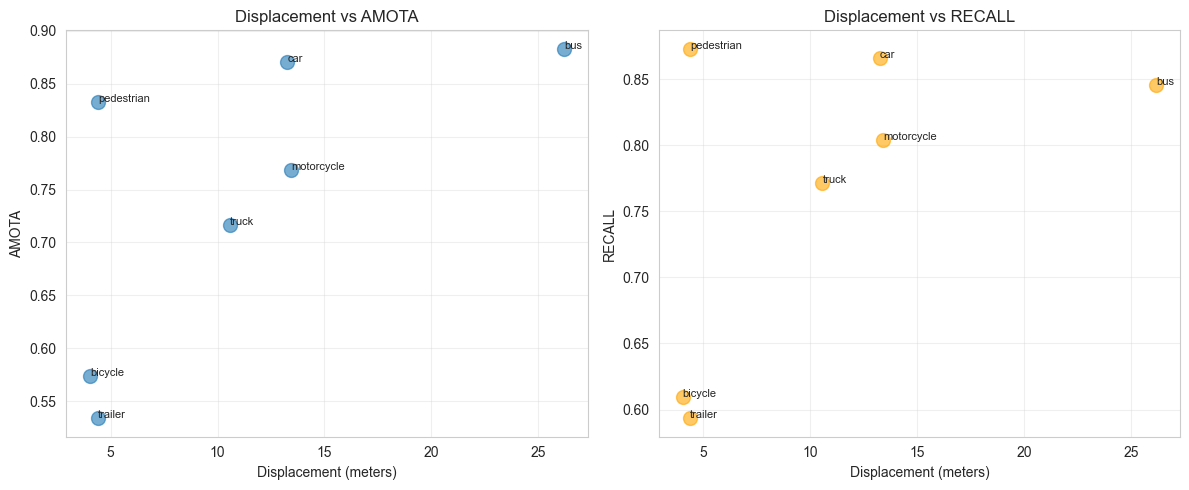

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
classes = ['trailer', 'bicycle', 'truck', 'motorcycle', 'pedestrian', 'car', 'bus']
amota = [0.5338312786, 0.5739121077, 0.7168514821, 0.7680373397, 0.8327717124, 0.8705222983, 0.8829414993]
recall = [0.5934020619, 0.6091319619, 0.7710880829, 0.803743045, 0.8728316878, 0.8662482638, 0.8451704545]
displacement = [4.402676, 4.04305, 10.585122, 13.424646, 4.402676, 13.260199, 26.191042]

# Exclude pedestrian (index 4)
exclude_idx = 4
classes_filtered = [cls for i, cls in enumerate(classes) if i != exclude_idx]
amota_filtered = [val for i, val in enumerate(amota) if i != exclude_idx]
recall_filtered = [val for i, val in enumerate(recall) if i != exclude_idx]
displacement_filtered = [val for i, val in enumerate(displacement) if i != exclude_idx]

# Create plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Displacement vs AMOTA
ax1.scatter(displacement_filtered, amota_filtered, s=100, alpha=0.6)
for i, cls in enumerate(classes_filtered):
    ax1.annotate(cls, (displacement_filtered[i], amota_filtered[i]), fontsize=8)

# Add trendline for AMOTA
z1 = np.polyfit(displacement_filtered, amota_filtered, 1)
p1 = np.poly1d(z1)
x_trend = np.linspace(min(displacement_filtered), max(displacement_filtered), 100)
ax1.plot(x_trend, p1(x_trend), "r--", alpha=0.8, linewidth=2, label=f'Trendline: y={z1[0]:.4f}x+{z1[1]:.4f}')

ax1.set_xlabel('Displacement (meters)')
ax1.set_ylabel('AMOTA')
ax1.set_title('Displacement vs AMOTA (excluding pedestrian)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Displacement vs RECALL
ax2.scatter(displacement_filtered, recall_filtered, s=100, alpha=0.6, color='orange')
for i, cls in enumerate(classes_filtered):
    ax2.annotate(cls, (displacement_filtered[i], recall_filtered[i]), fontsize=8)

# Add trendline for RECALL
z2 = np.polyfit(displacement_filtered, recall_filtered, 1)
p2 = np.poly1d(z2)
ax2.plot(x_trend, p2(x_trend), "r--", alpha=0.8, linewidth=2, label=f'Trendline: y={z2[0]:.4f}x+{z2[1]:.4f}')

ax2.set_xlabel('Displacement (meters)')
ax2.set_ylabel('RECALL')
ax2.set_title('Displacement vs RECALL (excluding pedestrian)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()